# TechCon Hackathon: Data Deploy a Solution

## Background

### Business Case

Cymbal Direct has traditionally shipped using 3rd party carriers.  In the last two years they started a direct delivery program, for a flat $20 charge. The new direct delivery program has been wildly successful because it has reduced delivery times and improved the customer experience.
However, in some locations there are not enough delivery services available to handle the demand.  Cymbal Direct has established a partnership with Yellow Taxi to handle delivery services.  
Cymbal needs to optimize its delivery operations to identify which delivery service is the most effective in terms of cost and delivery time.
Cymbal Shops would also like to use these delivery services to deliver their products directly to customers.


### Challenge
The existing model uses limited signals to determine optimal shipping method. It needs to be improved.



### Objectives
* Improve the existing model with new signals from the provided dataset. 
* Operationalize the model through Retraining and Deployment.
* Use the model to determine the optimal shipping method for Cymbal Direct.
* Develop a frontend to allow other Cymbal Shops to use the model.


### The dataset

[nyc-tlc.yellow_trips](https://go/nyc-tlc.yellow_trips)

* Dataset includes trip records for NYC Yellow Taxis since 2009. 
* Each row represents a single taxi cab ride.
* Includes fields on Pick-up / Drop-off coordinates and itemized fares.


### What has been deployed 
A VertexAI pipeline running a BigQueryML linear regression model has already been built. See instructions below for how to deploy it. 

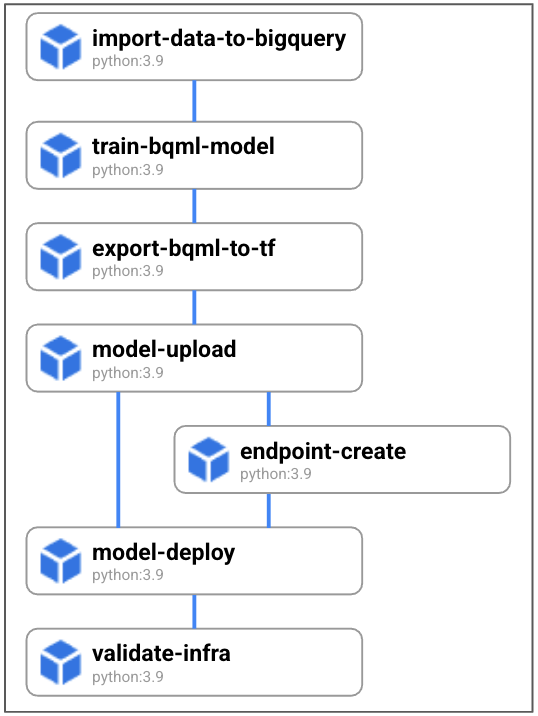

## Before you begin

### Set up your Google Cloud project

**The following steps are required, regardless of your notebook environment.**

1. [Select or create a Google Cloud project](https://console.cloud.google.com/cloud-resource-manager).

1. [Make sure that billing is enabled for your project](https://cloud.google.com/billing/docs/how-to/modify-project).

1. If you are running this notebook locally, you will need to install the [Cloud SDK](https://cloud.google.com/sdk).

1. You'll use the *gcloud* command throughout this notebook. In the following cell, enter your project name and run the cell to authenticate yourself with the Google Cloud and initialize your *gcloud* configuration settings.

**For this lab, we're going to use region us-central1 for all our resources (BigQuery training data, Cloud Storage bucket, model and endpoint locations, etc.). Those resources can be deployed in other regions, as long as they're consistently co-located, but we're going to use one fixed region to keep things as simple and error free as possible.**

### Install Pre-requisites


In [ ]:
import os

# The Google Cloud Notebook product has specific requirements
IS_GOOGLE_CLOUD_NOTEBOOK = os.path.exists("/opt/deeplearning/metadata/env_version")

# Google Cloud Notebook requires dependencies to be installed with '--user'
USER_FLAG = ""
if IS_GOOGLE_CLOUD_NOTEBOOK:
    USER_FLAG = "--user"

In [ ]:
# Install Python package dependencies.
print("Installing libraries")
! pip3 install {USER_FLAG} --quiet --upgrade google-cloud-pipeline-components==0.1.7 kfp==1.8.2
! pip3 install {USER_FLAG} --quiet --upgrade google-cloud-aiplatform==1.4.3 google-cloud-bigquery

Installing libraries
     |████████████████████████████████| 128 kB 7.2 MB/s 
     |████████████████████████████████| 248 kB 60.2 MB/s 
     |████████████████████████████████| 1.7 MB 63.9 MB/s 
     |████████████████████████████████| 127 kB 47.0 MB/s 
     |████████████████████████████████| 636 kB 30.1 MB/s 
     |████████████████████████████████| 106 kB 51.0 MB/s 
     |████████████████████████████████| 1.6 MB 40.0 MB/s 
     |████████████████████████████████| 54 kB 2.1 MB/s 
     |████████████████████████████████| 52 kB 1.2 MB/s 
     |████████████████████████████████| 56 kB 3.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 87 kB 5.1 MB/s 
     |████████████████████████████████| 10.1 MB 26.8 MB/s 
     |████████████████████████████████| 45 kB 2.5 MB/s 
     |████████████████████████████████| 105 kB 66.3 MB/s 
     |████████████████████████████████| 105 kB 54.3

In [ ]:
# Automatically restart kernel after installs
import os

if not os.getenv("IS_TESTING"):
    # Automatically restart kernel after installs
    import IPython

    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

NOTE: After this step, your runtime will be restarted to apply the new packages. Colab will throw an error that "Your session has crashed for an unknown reason". This is expected.

### Import Required Libraries

In [ ]:
import os
import sys
from datetime import datetime
from typing import NamedTuple

from google.cloud import storage
from google.cloud.storage import Bucket
from google.cloud import aiplatform as vertex
from google_cloud_pipeline_components import \
    aiplatform as vertex_pipeline_components
from kfp import dsl
from kfp.v2 import compiler
from kfp.v2.dsl import (Artifact, Dataset, Input, Metrics, Model, Output,
                        component)


### Determine Project Variables

Instructions:
- Make sure the GCS bucket and the BigQuery Dataset do not exist. This script may **delete** any existing content.
- Your bucket must be on the same region as your Vertex AI resources.
- BQ region can be US or EU;
- Make sure your preferred Vertex AI region is supported [[link]](https://cloud.google.com/vertex-ai/docs/general/locations#americas_1).


In [ ]:
PROJECT_ID = "hackathonvertexai2"  # @param {type:"string"}

# Get your Google Cloud project ID from gcloud
if not os.getenv("IS_TESTING"):
    shell_output=!gcloud config list --format 'value(core.project)' 2>/dev/null
    PROJECT_ID = shell_output[0]
    print("Project ID: ", PROJECT_ID)

Project ID:  


In [ ]:
if PROJECT_ID == "" or PROJECT_ID is None:
    PROJECT_ID = "hackathonvertexai2"  # @param {type:"string"}
    print("Project ID: ", PROJECT_ID)

Project ID:  hackathonvertexai2


In [ ]:
REGION = "us-central1"  # @param {type:"string"}
BUCKET_NAME = "hackathonvertexai2"  # @param {type:"string"}
PIPELINE_JSON_PKG_PATH = "2022_hackathon.json"
PIPELINE_ROOT = f"gs://{BUCKET_NAME}/pipeline_root"
TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")
DATA_FOLDER = f"{BUCKET_NAME}/data"

TEST_DATASET_CSV_LOCATION = f"gs://{DATA_FOLDER}/test_dataset"
BQ_DATASET = "hackathon_taxis"  # @param {type:"string"}
BQ_LOCATION = "US"  # @param {type:"string"}
BQ_LOCATION = BQ_LOCATION.upper()
BQML_EXPORT_LOCATION = f"gs://{BUCKET_NAME}/artifacts/bqml/"
GCS_BATCH_PREDICTION_OUTPUT_PREFIX = f"gs://{BUCKET_NAME}/predictions/"

image_prefix = REGION.split("-")[0]
BQML_SERVING_CONTAINER_IMAGE_URI = (
    f"{image_prefix}-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.2-6:latest"
)

### Authenticate with GCP

In [ ]:
import os

# The Google Cloud Notebook product has specific requirements
IS_GOOGLE_CLOUD_NOTEBOOK = os.path.exists("/opt/deeplearning/metadata/env_version")

# If on Google Cloud Notebooks, then don't execute this code
if not IS_GOOGLE_CLOUD_NOTEBOOK:
    if "google.colab" in sys.modules:
        from google.colab import auth as google_auth

        google_auth.authenticate_user()

    # If you are running this notebook locally, replace the string below with the
    # path to your service account key and run this cell to authenticate your GCP
    # account.
    elif not os.getenv("IS_TESTING"):
        %env GOOGLE_APPLICATION_CREDENTIALS ''

In [ ]:
if os.getenv("IS_TESTING"):
    !gcloud --quiet components install beta
    !gcloud --quiet components update
!gcloud config set project $PROJECT_ID
!gcloud config set ai/region $REGION

Updated property [core/project].
Updated property [ai/region].


### Create Cloud Storage Bucket

In [ ]:
storage_client = storage.Client(project=PROJECT_ID)
if not Bucket(storage_client, BUCKET_NAME).exists():
  bucket = storage_client.create_bucket(BUCKET_NAME)
  print("Bucket {} created".format(bucket.name))
else:
  print("Bucket {} exists".format(BUCKET_NAME))

Bucket hackathonvertexai2 exists


### Enable GCP APIs

In [ ]:
!gcloud services enable aiplatform.googleapis.com
!gcloud services enable compute.googleapis.com

## Pipeline Components
In this section we define the individual components of our workflow. In "The Pipeline" section we connect the steps together into a pipeline, and deploy it to VertexAI.

### (1) import_data_to_bigquery
This component takes a subset of data from 'nyc-tlc.yellow.trips' and imports it to a table in BigQuery. The subset of data in Bigquery will be the basis of our analysis. If the dataset does not exist, it will be created. If a table with the same name already exists, it will be deleted and recreated.

In [ ]:
@component(base_image="python:3.9", packages_to_install=["google-cloud-bigquery"])
def import_data_to_bigquery(
    project: str,
    bq_location: str,
    bq_dataset: str,
    dataset: Output[Dataset],
    table_name_prefix: str = "taxis",
):
    from google.cloud import bigquery

    # Construct a BigQuery client object.
    client = bigquery.Client(project=project, location=bq_location)

    def create_dataset_if_not_exist(bq_dataset_id, bq_location):
        print(
            "Checking for existence of bq dataset. If it does not exist, it creates one"
        )
        dataset = bigquery.Dataset(bq_dataset_id)
        dataset.location = bq_location
        dataset = client.create_dataset(dataset, exists_ok=True, timeout=300)
        print(f"Created dataset {dataset.full_dataset_id} @ {dataset.location}")
    
    def import_dataset(table_name_dataset):
        training_dataset_table_name = f"{project}.{bq_dataset}.{table_name_dataset}"
        query = f"""
        CREATE OR REPLACE TABLE
            `{training_dataset_table_name}`
           AS
        SELECT
          pickup_longitude,
          pickup_latitude,
          dropoff_longitude,
          dropoff_latitude,
          fare_amount
        FROM
          `nyc-tlc.yellow.trips` f
        WHERE
          MOD(ABS(FARM_FINGERPRINT(CAST(pickup_datetime AS STRING))), 10000) = 1;
        """
        print("Importing the dataset")
        query_job = client.query(query)  # Make an API request.
        query_job.result()
        print(query.replace("\n", " "))
        return training_dataset_table_name

    bq_dataset_id = f"{project}.{bq_dataset}"
    create_dataset_if_not_exist(bq_dataset_id, bq_location)

    table_name_dataset = "taxifare"
    dataset_uri = import_dataset(table_name_dataset)

    dataset.uri = dataset_uri


### (2) train_bqml_model
On this demo, we will use a simple linear regression model on BQML. However, you can be creative with other model architectures, such as Deep Neural Networks, XGboost, Logistic Regression, etc.

For a full list of models supported by BQML, look here: [End-to-end user journey for each model](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-e2e-journey)

BQML also supports **Hyperparameter Tuning**. On this demo, we are doing 4 different trials. You can expand this following the documentation: [BigQuery ML Hyperparameter Tuning Overview](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-hp-tuning-overview)

In [ ]:
@component(base_image="python:3.9", packages_to_install=["google-cloud-bigquery"])
def train_bqml_model(
    dataset: Input[Dataset],
    bqml_model: Output[Artifact],
    bq_location: str,
    model_name: str = "linear_regression_model",
    num_trials: int = 4,
) -> NamedTuple("bqml_training", [("query", str)]):
    from collections import namedtuple

    from google.cloud import bigquery

    dataset_uri = dataset.uri
    table_name = dataset_uri.split("bq://")[-1]
    print(table_name)
    uri_parts = table_name.split(".")
    print(uri_parts)
    project = uri_parts[0]
    bq_dataset = uri_parts[1]

    client = bigquery.Client(project=project, location=bq_location)

    model_table_name = f"{project}.{bq_dataset}.{model_name}"

    model_options = """OPTIONS
      ( MODEL_TYPE='LINEAR_REG',
        #LS_INIT_LEARN_RATE=0.15,
        #L1_REG=1,
        input_label_cols=['fare_amount']
        
    """
    if num_trials > 0:
        model_options += f""", 
        
        NUM_TRIALS={num_trials},
        HPARAM_TUNING_OBJECTIVES=['mean_squared_error']"""
    model_options += ")" ""

    query = f"""
    CREATE OR REPLACE MODEL
      `{model_table_name}`
      {model_options}
     AS
    SELECT
      pickup_longitude,
      pickup_latitude,
      dropoff_longitude,
      dropoff_latitude,
      fare_amount
    FROM
      `{table_name}`;
    """

    print(query.replace("\n", " "))
    query_job = client.query(query)  # Make an API request.
    print(query_job.job_id)
    query_job.result()
    bqml_model.uri = f"bq://{model_table_name}"
    print(bqml_model)
    print(f"bq://{model_table_name}")

    result_tuple = namedtuple("bqml_training", ["query"])

    return result_tuple(query=str(query))

### (3) export_bqml_to_tf
Once the BQML model is trained, you will need to export it to a GCS bucket, so it can later be imported to Vertex AI.

For more information on exporting your model, please follow the [documentation].(https://cloud.google.com/bigquery-ml/docs/exporting-models)

The doc above also talks about limitations on the model export statement.

As of September 2021, an important one to be aware is the following:

* The model doesn't contain the information about the feature engineering performed in the SELECT statement during training, so you would need to manually convert the input data before feeding into the exported model.

In [ ]:
@component(base_image="python:3.9", packages_to_install=["google-cloud-bigquery"])
def export_bqml_to_tf(
    project: str,
    export_location: str,
    bqml_model: Input[Model],
    tf_model: Output[Artifact],
    bq_location: str,
):
    from google.cloud import bigquery

    bqml_table_name = bqml_model.uri.split("/")[-1]
    query = f"""
     EXPORT MODEL `{bqml_table_name}`
    OPTIONS(URI = '{export_location}')

    """
    client = bigquery.Client(project=project, location=bq_location)
    query_job = client.query(query)
    query_job.result()

    tf_model.uri = export_location
    print("tf_model.uri :%s"%export_location)

### (4) validate_infra
Now that the best model has been deployed, we will validate the endpoint by making a simple prediction to it.

In [ ]:
@component(base_image="python:3.9", packages_to_install=["google-cloud-aiplatform"])
def validate_infra(
    endpoint: Input[Artifact],
) -> NamedTuple(
    "validate_infrastructure_output", [("instance", str), ("prediction", float)]
):
    import json
    from collections import namedtuple

    from google.cloud import aiplatform
    from google.protobuf import json_format
    from google.protobuf.struct_pb2 import Value

    def treat_uri(uri):
        return uri[uri.find("projects/") :]

    def request_prediction(endp, instance):
        instance = json_format.ParseDict(instance, Value())
        instances = [instance]
        parameters_dict = {}
        parameters = json_format.ParseDict(parameters_dict, Value())
        response = endp.predict(instances=instances, parameters=parameters)
        print("deployed_model_id:", response.deployed_model_id)
        print("predictions: ", response.predictions)
        # The predictions are a google.protobuf.Value representation of the model's predictions.
        predictions = response.predictions

        for pred in predictions:
            if type(pred) is dict and "value" in pred.keys():
                # AutoML predictions
                prediction = pred["value"]
            elif type(pred) is list:
                # BQML Predictions return different format
                prediction = pred[0]
            return prediction

    endpoint_uri = endpoint.uri
    treated_uri = treat_uri(endpoint_uri)

    instance = {
        "pickup_longitude":-74.002387,
        "pickup_latitude":40.719832,
        "dropoff_longitude":-74.00239,
        "dropoff_latitude":40.719825
    }
    instance_json = json.dumps(instance)
    print("Will use the following instance: " + instance_json)

    endpoint = aiplatform.Endpoint(treated_uri)
    prediction = request_prediction(endpoint, instance)
    result_tuple = namedtuple(
        "validate_infrastructure_output", ["instance", "prediction"]
    )

    return result_tuple(instance=str(instance_json), prediction=float(prediction))

## Execute The Pipeline

Now that we have defined the components of our pipeline, we connect them together in the train_pipeline function. 

In [ ]:
DISPLAY_NAME = "taxi-fare-prediction"

pipeline_params = {
    "project": PROJECT_ID,
    "region": REGION,
    "bq_dataset": BQ_DATASET,
    "bq_location": BQ_LOCATION,
    "bqml_model_export_location": BQML_EXPORT_LOCATION,
    "bqml_serving_container_image_uri": BQML_SERVING_CONTAINER_IMAGE_URI,
    "test_dataset_folder": TEST_DATASET_CSV_LOCATION,
    "gcs_batch_prediction_output_prefix": GCS_BATCH_PREDICTION_OUTPUT_PREFIX,
    "thresholds_dict_str": '{"rmse": 20.0}',
}

In [ ]:
@dsl.pipeline(name=DISPLAY_NAME, description="Rapid Prototyping")
def train_pipeline(
    project: str,
    region: str,
    bq_dataset: str,
    bq_location: str,
    bqml_model_export_location: str,
    bqml_serving_container_image_uri: str,
    test_dataset_folder: str,
    gcs_batch_prediction_output_prefix: str,
    thresholds_dict_str: str,
):
    # Adding these lines temporarily to prevent a runtime error.
    vertex_pipeline_components.ModelUploadOp.component_spec.implementation.container.image = "gcr.io/ml-pipeline/google-cloud-pipeline-components:0.1.7"
    vertex_pipeline_components.ModelDeployOp.component_spec.implementation.container.image = "gcr.io/ml-pipeline/google-cloud-pipeline-components:0.1.7"
    vertex_pipeline_components.EndpointCreateOp.component_spec.implementation.container.image = "gcr.io/ml-pipeline/google-cloud-pipeline-components:0.1.7"
    
    job_display_name = f"{DISPLAY_NAME}_job"

    print("running")

    # (1) - Import data to BigQuery
    import_data_to_bigquery_op = import_data_to_bigquery(
      project, bq_location, bq_dataset
    )
    dataset = import_data_to_bigquery_op.outputs["dataset"]

    # (2) - Train BQML Model
    train_bqml_model_op = train_bqml_model(dataset, bq_location=bq_location)

    bqml_trained_model = train_bqml_model_op.outputs["bqml_model"]

    # (3) - Export BQML Model
    export_bqml_to_tf_op = export_bqml_to_tf(
        export_location=bqml_model_export_location,
        project=project,
        bqml_model=bqml_trained_model,
        bq_location=bq_location,
    )

    bqml_model_upload_op = vertex_pipeline_components.ModelUploadOp(
        project=project,
        location=region,
        display_name=DISPLAY_NAME + "_bqml",
        artifact_uri=bqml_model_export_location,
        serving_container_image_uri=bqml_serving_container_image_uri,
    )

    bqml_model_upload_op.after(export_bqml_to_tf_op)

    bqml_model = bqml_model_upload_op.outputs["model"]

    endpoint_create_op = vertex_pipeline_components.EndpointCreateOp(
        project=project,
        location=region,
        display_name=f"{DISPLAY_NAME}_endpoint",
    )

    endpoint_create_op.after(bqml_model_upload_op)

    #(4) - Validate Infrastructure
    model_deploy_op = vertex_pipeline_components.ModelDeployOp(  # noqa: F841
        project=project,
        location=region,
        endpoint=endpoint_create_op.outputs["endpoint"],
        model=bqml_model,
        deployed_model_display_name=DISPLAY_NAME + "_best",
        machine_type="n1-standard-2",
        # traffic_percentage=100
    ).set_caching_options(False)

    validate_infra_task = validate_infra(
        endpoint=model_deploy_op.outputs["endpoint"]
    ).set_caching_options(False)

    validate_infra_task.after(model_deploy_op)

After we've defined our pipeline, we compile it and execute it on VertexAI.

In [ ]:
compiler.Compiler().compile(
    pipeline_func=train_pipeline,
    package_path=PIPELINE_JSON_PKG_PATH,
)

vertex.init(project=PROJECT_ID, location=REGION)

pipeline_job = vertex.PipelineJob(
    display_name=DISPLAY_NAME,
    template_path=PIPELINE_JSON_PKG_PATH,
    pipeline_root=PIPELINE_ROOT,
    parameter_values=pipeline_params,
    enable_caching=False,
)

response = pipeline_job.run()

print(response)